In [92]:
import pandas as pd
import geopandas as gpd
import os
import inspect
from functools import lru_cache
import requests
from census import Census # https://pypi.org/project/census/
from us import states
import matplotlib.pyplot as plt

In [93]:
# City Boundaries
# Data source:
census_tracts = gpd.read_file("../data/raw/tl_2023_06_tract", layer="tl_2023_06_tract") # ctys

census_tracts.head()

# STATEFP: The State FIPS (Federal Information Processing Standard) code, which is a two-digit code that uniquely identifies each U.S. state.
# COUNTYFP: The County FIPS code, a three-digit code that, when combined with the State FIPS code, uniquely identifies a county within the United States.
# TRACTCE: The Census Tract code, which is a statistical geographic area designed to be relatively homogenous in population characteristics, economic status, and living conditions.
# GEOID: A concatenation of the STATEFP, COUNTYFP, and TRACTCE codes, creating a unique identifier for each census tract within the nation.
# GEOIDFQ: Likely stands for 'GEOID Fully Qualified', another format of a unique identifier for the geographic entity.
# NAME: The basic or short name of the geographic entity, which is the census tract number in this context.
# NAMELSAD: The name and the legal/statistical area description for the tract (e.g., Census Tract 4427).
# MTFCC: The MAF/TIGER Feature Class Code, which describes the type of feature represented by the record (G5020 typically denotes an area feature such as a census tract).
# FUNCSTAT: Functional status of the entity, which describes whether the geographic entity is active and functioning (e.g., 'S' for statistical).
# ALAND: Land area in square meters.
# AWATER: Water area in square meters.
# INTPTLAT: The latitude of the internal point (or centroid) of the feature.
# INTPTLON: The longitude of the internal point (or centroid) of the feature.
# geometry: The geometric data that defines the shape of the feature, which in this case is a polygon representing the boundaries of the census tract.

STATEFP COUNTYFP TRACTCE        GEOID               GEOIDFQ     NAME  \
0      06      001  442700  06001442700  1400000US06001442700     4427   
1      06      001  442800  06001442800  1400000US06001442800     4428   
2      06      037  204920  06037204920  1400000US06037204920  2049.20   
3      06      037  205110  06037205110  1400000US06037205110  2051.10   
4      06      037  320101  06037320101  1400000US06037320101  3201.01   

               NAMELSAD  MTFCC FUNCSTAT    ALAND  AWATER     INTPTLAT  \
0     Census Tract 4427  G5020        S  1234016       0  +37.5371513   
1     Census Tract 4428  G5020        S  1278646       0  +37.5293619   
2  Census Tract 2049.20  G5020        S   909972       0  +34.0175004   
3  Census Tract 2051.10  G5020        S   286962       0  +34.0245059   
4  Census Tract 3201.01  G5020        S   680504       0  +34.2992784   

       INTPTLON                                           geometry  
0  -122.0081095  POLYGON ((-122.01721 37.53932, -122.01719 37.5...  
1  -121.9931002  POLYGON ((-122.00230 37.52984, -122.00224 37.5...  
2  -118.1974975  POLYGON ((-118.20284 34.01966, -118.20283 34.0...  
3  -118.2142985  POLYGON ((-118.21963 34.02629, -118.21945 34.0...  
4  -118.4326573  POLYGON ((-118.43882 34.29911, -118.43732 34.3...

In [94]:
# Plot census tracts
# census_tracts = census_tracts.to_crs(epsg=3310)
# Explore data here: https://maps.geo.census.gov/ddmv/map.html

# # Check CRS of both GeoDataFrames
# print(census_tracts.crs)
# # Filter for GEOID starting with 06001 (Alameda County)
# census_tracts_alameda = census_tracts[census_tracts['GEOID'].str.startswith('06001423')] # 06001423

# ax = census_tracts_alameda.plot(color='blue', edgecolor='black')
# plt.title('Alameda Census Tract Coverage')
# plt.show()

In [95]:
API_KEY = 'fc4be657d136b52dec85d920edaec5702e905e6f'
c = Census(API_KEY)

# Get a list of all variables for ACS 5-year 2019
variables_url = 'https://api.census.gov/data/2019/acs/acs5/variables.json'
response = requests.get(variables_url)
variables_data = response.json()

# Extract variable names, excluding non-data descriptor fields
variable_names = [var for var, details in variables_data['variables'].items() if var not in ('for', 'in', 'ucgid')]
print(variable_names)

# Display some variable descriptions
for var in ['B24042_022E', 'B20005_020E', 'B08201_008E']:
    description = variables_data['variables'][var]['label']
    concept = variables_data['variables'][var]['concept']
    print(f"{var}: {description} - {concept}")

['B24022_060E', 'B19001B_014E', 'B07007PR_019E', 'B19101A_004E', 'B24022_061E', 'B19001B_013E', 'B07007PR_018E', 'B19101A_005E', 'B24022_062E', 'B19001B_012E', 'B01001B_029E', 'B19101A_006E', 'B20005A_021E', 'B07007PR_017E', 'B24022_063E', 'B07007PR_015E', 'B19001B_011E', 'B19101A_007E', 'B20005A_020E', 'B07007PR_016E', 'B24022_064E', 'B19001B_010E', 'B26209_011E', 'B01001B_027E', 'B20005A_023E', 'B26209_010E', 'B24022_065E', 'B01001B_028E', 'B19101A_001E', 'B20005A_022E', 'B24022_066E', 'B01001B_025E', 'B20005A_025E', 'B19101A_002E', 'B19037E_030E', 'B24022_067E', 'B01001B_026E', 'B19101A_003E', 'B20005A_024E', 'B07007PR_010E', 'B07004H_002E', 'B01001B_022E', 'B20005_028E', 'B01001B_023E', 'B07004H_001E', 'B20005_029E', 'B01001B_024E', 'B01001B_020E', 'B20005_026E', 'B06004E_001E', 'B01001B_021E', 'B20005_027E', 'B06004E_002E', 'B07004H_006E', 'B07007PR_014E', 'B08119_021E', 'B06004E_003E', 'B07004H_005E', 'B07007PR_013E', 'B19001B_017E', 'B08119_020E', 'B06004E_004E', 'B07007PR_012E'

In [96]:
@lru_cache(maxsize=None)  # Caching without any limit
def get_census_data():
    return c.acs5.state_county(('NAME', 'B01003_001E', 'B19013_001E'), 
                              states.CA.fips, 
                              Census.ALL,
                              year=2021)

response = get_census_data()

In [97]:
# Print each county's name and population
for data in response:
    county_name = data['NAME']
    median_income = data['B19013_001E']
    if median_income is None:
        median_income = 'Data Not Available'
    print(f"{county_name}: Median Income - ${median_income}")
    print(data['NAME'], data['B01003_001E'])
    print("******")

Alameda County, California: Median Income - $112017.0
Alameda County, California 1673133.0
******
Alpine County, California: Median Income - $96000.0
Alpine County, California 1344.0
******
Amador County, California: Median Income - $69955.0
Amador County, California 40095.0
******
Butte County, California: Median Income - $59863.0
Butte County, California 217884.0
******
Calaveras County, California: Median Income - $70119.0
Calaveras County, California 45349.0
******
Colusa County, California: Median Income - $61861.0
Colusa County, California 21780.0
******
Contra Costa County, California: Median Income - $110455.0
Contra Costa County, California 1161643.0
******
Del Norte County, California: Median Income - $53280.0
Del Norte County, California 27655.0
******
El Dorado County, California: Median Income - $88770.0
El Dorado County, California 190568.0
******
Fresno County, California: Median Income - $61276.0
Fresno County, California 1003150.0
******
Glenn County, California: Media

In [98]:
# Get all methods of an object that are not built-in methods
methods = [method for method in dir(c) if not method.startswith('__')]
for method in methods:
    method_obj = getattr(c, method)
    if inspect.ismethod(method_obj) or inspect.isfunction(method_obj):
        print(method, inspect.signature(method_obj))

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')


ValueError: aspect must be finite and positive 

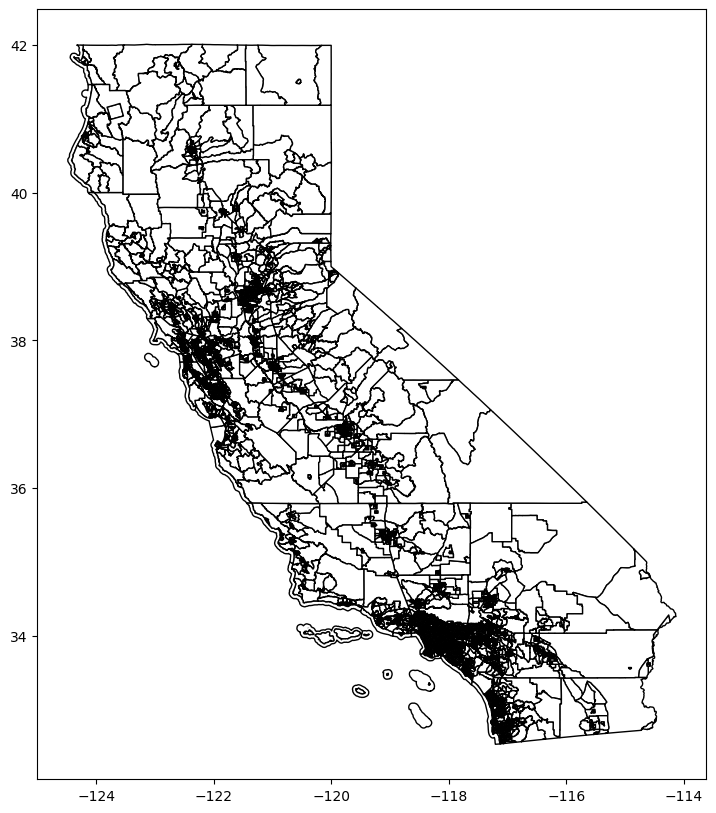

In [116]:
# URL for downloading shapefiles, counties (2023)
shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip"

# Read the shapefile directly using geopandas
counties = gpd.read_file(shapefile_url)

# Counties in California (state FIPS code: '06')
california_counties = counties[counties['STATEFP'] == '06']

print(california_counties.columns)

# Get a specific county's geometry
alameda_county = california_counties[california_counties['NAME'] == 'Alameda']

fig, ax = plt.subplots(figsize=(10, 10))
california_counties.plot(ax=ax, color='white', edgecolor='black')
alameda_county.plot(ax=ax, color='lightblue', edgecolor='blue')
ax.set_title("California Counties - Los Angeles Highlighted", fontsize=15)
plt.show()

In [117]:
# Retrieve median household income (B19013_001E) for all California counties (2021 data)
# Define your API key and instantiate the Census API client
# URL for downloading shapefiles, counties (2023)

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [118]:
@lru_cache(maxsize=None)  # Caching without any limit
def get_census_tract_data():
    return c.acs5.state_county(('NAME', 'B19013_001E'), states.CA.fips, Census.ALL, year=2021)

response_tracts = get_census_tract_data()

count      8991.000000
mean      91314.788455
std       43086.832617
min        8667.000000
25%       59928.000000
50%       82734.000000
75%      112457.500000
max      250001.000000
Name: B19013_001E, dtype: float64


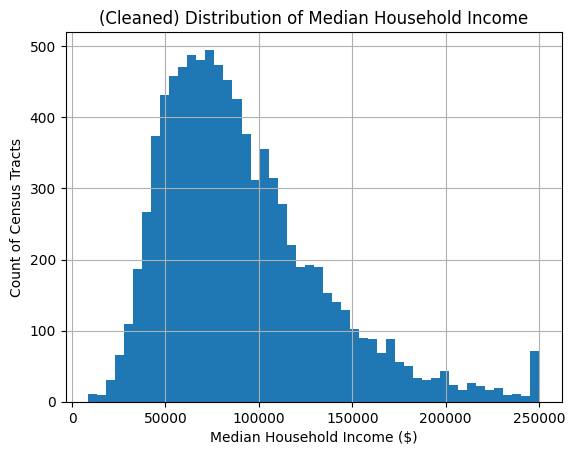

In [198]:
shapefile_url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_06_tract.zip"
tracts = gpd.read_file(shapefile_url)

@lru_cache(maxsize=None)  # Caching without any limit
def get_census_tract_data():
    return c.acs5.state_county_tract(('NAME', 'B19013_001E'), states.CA.fips, Census.ALL, Census.ALL, year=2021)

response_tracts = get_census_tract_data()

# Convert the API response to a DataFrame
api_df = pd.DataFrame(response_tracts)

# Retrieve median household income at the tract level in California (2021 data)

# Convert the county FIPS codes to strings and zero-pad them to 3 digits for proper matching
api_df['STATEFP'] = api_df['state'].apply(lambda x: str(x).zfill(2))
api_df['COUNTYFP'] = api_df['county'].apply(lambda x: str(x).zfill(3))
api_df['tract'] = api_df['tract'].apply(lambda x: str(x).zfill(6))
api_df['GEOID'] = api_df['STATEFP'] + api_df['COUNTYFP'] + api_df['tract']
api_df['B19013_001E'] = pd.to_numeric(api_df['B19013_001E'], errors='coerce')

api_df.head()

# # Merge with geographic shapefiles using COUNTYFP and STATEFP fields
merged_gdf = tracts.merge(api_df, on='GEOID')
merged_gdf.head()
# negative_values = merged_gdf[merged_gdf['B19013_001E'] < 0]
# print("Negative values in the dataset:")
# print(negative_values['B19013_001E'])
# Check value counts to see the distribution
# bounds_bay_area_x = [-122.8, -121.7]
# bounds_bay_area_y = [37.5, 38.1]

# Replace negative values with NaN or filter them out entirely
merged_gdf.loc[merged_gdf['B19013_001E'] < 0, 'B19013_001E'] = float('nan')
# Alternatively, drop rows with negative or missing income values
merged_gdf_clean = merged_gdf[merged_gdf['B19013_001E'] >= 0].dropna(subset=['B19013_001E'])

print(merged_gdf_clean['B19013_001E'].describe())

merged_gdf_clean['B19013_001E'].hist(bins=50)
plt.xlabel('Median Household Income ($)')
plt.ylabel('Count of Census Tracts')
plt.title('(Cleaned) Distribution of Median Household Income')
plt.show()

# Plot the merged data (geometry with median income)
fig, ax = plt.subplots(figsize=(10, 10))
merged_gdf.plot(column='B19013_001E', ax=ax, legend=True, cmap='OrRd', edgecolor='black')

# # Set the x and y axis limits to focus on the Bay Area
ax.set_xlim(bounds_bay_area_x)
ax.set_ylim(bounds_bay_area_y)

# # Add title
# ax.set_title("Bay Area Census Tracts - Median Household Income", fontsize=15)
# plt.show()

In [199]:
# Print the first few rows of the API data to verify the values
print("API DataFrame (first rows):")
api_df.head()

API DataFrame (first rows):


NAME  B19013_001E state county  \
0  Census Tract 4001, Alameda County, California     224821.0    06    001   
1  Census Tract 4002, Alameda County, California     201154.0    06    001   
2  Census Tract 4003, Alameda County, California     127333.0    06    001   
3  Census Tract 4004, Alameda County, California     146265.0    06    001   
4  Census Tract 4005, Alameda County, California     101597.0    06    001   

    tract STATEFP COUNTYFP        GEOID  
0  400100      06      001  06001400100  
1  400200      06      001  06001400200  
2  400300      06      001  06001400300  
3  400400      06      001  06001400400  
4  400500      06      001  06001400500

In [200]:
# Check if there are missing values in the B19013_001E column
missing_income = api_df['B19013_001E'].isnull().sum()
print(f"Number of missing values in B19013_001E: {missing_income}")

Number of missing values in B19013_001E: 0


In [201]:
# Verify the merged data's first few rows
print("Merged GeoDataFrame (first rows):")
merged_gdf.head()

Merged GeoDataFrame (first rows):


STATEFP_x COUNTYFP_x TRACTCE        GEOID               GEOIDFQ   NAME_x  \
0        06        001  442700  06001442700  1400000US06001442700     4427   
1        06        001  442800  06001442800  1400000US06001442800     4428   
2        06        037  204920  06037204920  1400000US06037204920  2049.20   
3        06        037  205110  06037205110  1400000US06037205110  2051.10   
4        06        037  320101  06037320101  1400000US06037320101  3201.01   

               NAMELSAD  MTFCC FUNCSTAT    ALAND  ...     INTPTLAT  \
0     Census Tract 4427  G5020        S  1234016  ...  +37.5371513   
1     Census Tract 4428  G5020        S  1278646  ...  +37.5293619   
2  Census Tract 2049.20  G5020        S   909972  ...  +34.0175004   
3  Census Tract 2051.10  G5020        S   286962  ...  +34.0245059   
4  Census Tract 3201.01  G5020        S   680504  ...  +34.2992784   

       INTPTLON                                           geometry  \
0  -122.0081095  POLYGON ((-122.01721 37.53932, -122.01719 37.5...   
1  -121.9931002  POLYGON ((-122.00230 37.52984, -122.00224 37.5...   
2  -118.1974975  POLYGON ((-118.20284 34.01966, -118.20283 34.0...   
3  -118.2142985  POLYGON ((-118.21963 34.02629, -118.21945 34.0...   
4  -118.4326573  POLYGON ((-118.43882 34.29911, -118.43732 34.3...   

                                              NAME_y B19013_001E  state  \
0      Census Tract 4427, Alameda County, California    177399.0     06   
1      Census Tract 4428, Alameda County, California    142177.0     06   
2  Census Tract 2049.20, Los Angeles County, Cali...     69125.0     06   
3  Census Tract 2051.10, Los Angeles County, Cali...     49750.0     06   
4  Census Tract 3201.01, Los Angeles County, Cali...     95909.0     06   

  county   tract STATEFP_y COUNTYFP_y  
0    001  442700        06        001  
1    001  442800        06        001  
2    037  204920        06        037  
3    037  205110        06        037  
4    037  320101        06        037  

[5 rows x 21 columns]

  STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  MTFCC  \
0      06      029  004402  06029004402    44.02    Census Tract 44.02  G5020   
1      06      047  000802  06047000802     8.02     Census Tract 8.02  G5020   
2      06      085  501402  06085501402  5014.02  Census Tract 5014.02  G5020   
3      06      005  000102  06005000102     1.02     Census Tract 1.02  G5020   
4      06      029  004901  06029004901    49.01    Census Tract 49.01  G5020   

  FUNCSTAT      ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S    1865739        0  +35.5917343  -119.3337642   
1        S    2321653        0  +37.3433591  -120.5854604   
2        S     522620        0  +37.3453341  -121.8665169   
3        S  456204155  7940832  +38.5496993  -120.2509786   
4        S    1459379        0  +35.7837173  -119.2462266   

                                            geometry  
0  POLYGON ((-119.33828 35.58143, -119.33827 35.5...  
1  POLYGON ((-120.59599 37.34121, -1

/Users/ana/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


       FeederId      FeederName                                Globalid  \
4280  012041111  OAKLAND D 1111  {54D41AF4-77A0-42F0-B8B8-922A25C616C6}   
4927  012041111  OAKLAND D 1111  {55E165E2-693B-4EEE-AA08-518ABFF9D829}   
4927  012041111  OAKLAND D 1111  {55E165E2-693B-4EEE-AA08-518ABFF9D829}   
4986  012041111  OAKLAND D 1111  {54A0103A-F4CE-4FEE-B1D0-C4A40B13CC1C}   
9626  012041111  OAKLAND D 1111  {5C5EF80E-F396-4043-B05B-8146374D9A25}   

      CSV_LineSection ICA_Analysis_Date  LoadCapacity_kW  GenCapacity_kW  \
4280          4392957          Jul 2023             2060            2490   
4927          4714729          Jul 2023              950             190   
4927          4714729          Jul 2023              950             190   
4986          4162116          Jul 2023              650            1150   
9626          3674001          Jul 2023              800            2490   

      GenericPVCapacity_kW  GenCapacity_no_OpFlex_kW  \
4280                  3260          

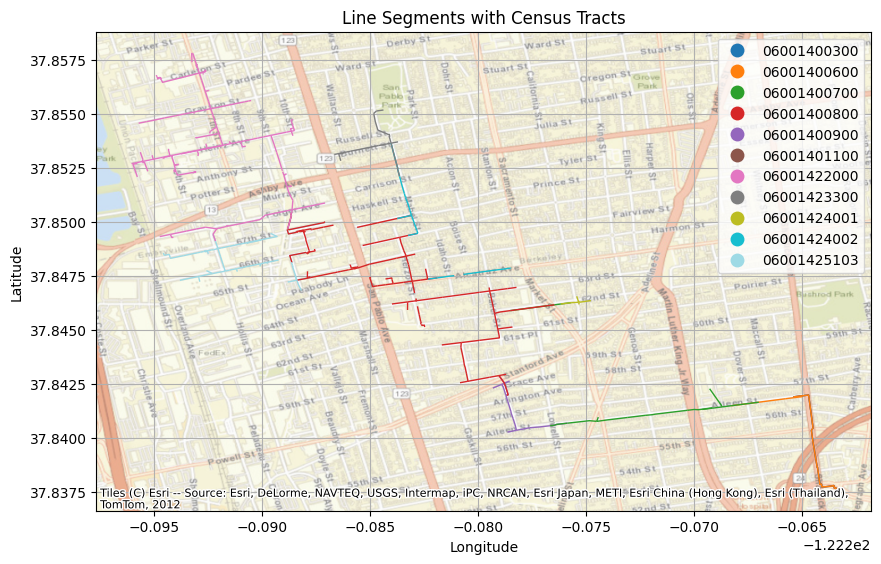

In [204]:
import requests
import geopandas as gpd
from census import Census
import matplotlib.pyplot as plt
import contextily as ctx

# Define your Census API key
API_KEY = 'fc4be657d136b52dec85d920edaec5702e905e6f'
c = Census(API_KEY)

# Define the URL for the TIGER/Line shapefile
shapefile_url = 'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_06_tract.zip'

# Download the shapefile
shapefile_path = 'tl_2020_06_tract.zip'
response = requests.get(shapefile_url)
with open(shapefile_path, 'wb') as file:
    file.write(response.content)

# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(f"zip://{shapefile_path}")

# Display the first few rows of the GeoDataFrame
print(gdf.head())

# Extract the required columns (e.g., GEOID and geometry)
census_tracts_gdf = gdf[['GEOID', 'geometry']]
print(census_tracts_gdf.head())

# Step 1: Download Census Tract Shapefile for California
shapefile_url = 'https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_06_tract.zip'
shapefile_path = 'tl_2020_06_tract.zip'
response = requests.get(shapefile_url)
with open(shapefile_path, 'wb') as file:
    file.write(response.content)

# Load the shapefile into a GeoDataFrame
census_tracts = gpd.read_file(f"zip://{shapefile_path}")

# Step 2: Load Line Data from the geodatabase
# feeder = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederDetail")
# feeder_load = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederLoadProfile")
line = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="LineDetail")
# substations = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="Substations")
# substation_load = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="SubstationLoadProfile")

# Step 3: Filter Line Data for a Specific Feeder
feeder_name = 'OAKLAND D 1111'
filtered_lines = line[line['FeederName'] == feeder_name]

# Step 4: Ensure CRS Matches
filtered_lines = filtered_lines.to_crs(census_tracts.crs)

# Step 5: Perform Spatial Join
joined = gpd.sjoin(filtered_lines, census_tracts, how="left", op="intersects")

# Display the first few rows of the joined data
print(joined.head())

# Step 6: Extract relevant properties and plot
# Example: Plotting lines color-coded by Census Tract ID (GEOID)
fig, ax = plt.subplots(figsize=(10, 10))

# Use the 'tab20' colormap for up to 20 unique colors (adjust accordingly)
cmap = plt.get_cmap('tab20', len(joined['GEOID'].unique()))

# Plot the joined lines with different colors for different census tracts
joined.plot(column='GEOID', cmap=cmap, ax=ax, linewidth=1, legend=True)

# Add basemap
ctx.add_basemap(ax, crs=joined.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, alpha=0.8)

ax.set_title("Line Segments with Census Tracts")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.show()

In [205]:
# Step 6: Group by Census Tract and Aggregate Line Segment Information
grouped = joined.groupby('GEOID').agg({
    'FeederId': list,
    'FeederName': list,
    'Globalid': list,
    'CSV_LineSection': list,
    'ICA_Analysis_Date': list,
    'LoadCapacity_kW': list,
    'GenCapacity_kW': list,
    'GenericPVCapacity_kW': list,
    'GenCapacity_no_OpFlex_kW': list,
    'GenericCapacity_no_OpFlex_kW': list,
    'Shape_Length': list
}).reset_index()

# Step 7: Display the Table
# Convert to pandas DataFrame for better readability if necessary
summary_table = pd.DataFrame(grouped)

# Display the first few rows of the table
print(summary_table.head())

# Optionally, save the table to a CSV file for further analysis
summary_table.to_csv("census_tracts_line_segments.csv", index=False)

         GEOID                                           FeederId  \
0  06001400300                                        [012041111]   
1  06001400600  [012041111, 012041111, 012041111, 012041111, 0...   
2  06001400700  [012041111, 012041111, 012041111, 012041111, 0...   
3  06001400800  [012041111, 012041111, 012041111, 012041111, 0...   
4  06001400900  [012041111, 012041111, 012041111, 012041111, 0...   

                                          FeederName  \
0                                   [OAKLAND D 1111]   
1  [OAKLAND D 1111, OAKLAND D 1111, OAKLAND D 111...   
2  [OAKLAND D 1111, OAKLAND D 1111, OAKLAND D 111...   
3  [OAKLAND D 1111, OAKLAND D 1111, OAKLAND D 111...   
4  [OAKLAND D 1111, OAKLAND D 1111, OAKLAND D 111...   

                                            Globalid  \
0           [{9EF51237-96DA-452B-B513-DD17340CC80A}]   
1  [{03429689-9747-4B47-A13B-C7B84948040E}, {9113...   
2  [{04FCB095-125F-41EC-9A1B-4B782651B1D8}, {0856...   
3  [{54D41AF4-77A0-42F0-

In [281]:
joined.head()

FeederId      FeederName                                Globalid  \
4280  012041111  OAKLAND D 1111  {54D41AF4-77A0-42F0-B8B8-922A25C616C6}   
4927  012041111  OAKLAND D 1111  {55E165E2-693B-4EEE-AA08-518ABFF9D829}   
4927  012041111  OAKLAND D 1111  {55E165E2-693B-4EEE-AA08-518ABFF9D829}   
4986  012041111  OAKLAND D 1111  {54A0103A-F4CE-4FEE-B1D0-C4A40B13CC1C}   
9626  012041111  OAKLAND D 1111  {5C5EF80E-F396-4043-B05B-8146374D9A25}   

      CSV_LineSection ICA_Analysis_Date  LoadCapacity_kW  GenCapacity_kW  \
4280          4392957          Jul 2023             2060            2490   
4927          4714729          Jul 2023              950             190   
4927          4714729          Jul 2023              950             190   
4986          4162116          Jul 2023              650            1150   
9626          3674001          Jul 2023              800            2490   

      GenericPVCapacity_kW  GenCapacity_no_OpFlex_kW  \
4280                  3260                     10000   
4927                   290                      5230   
4927                   290                      5230   
4986                  1470                      1150   
9626                  3260                      4560   

      GenericCapacity_no_OpFlex_kW  ...  MTFCC FUNCSTAT    ALAND   AWATER  \
4280                         10000  ...  G5020        S   725817        0   
4927                          6980  ...  G5020        S   876078        0   
4927                          6980  ...  G5020        S  4504647  5864364   
4986                          1470  ...  G5020        S  4504647  5864364   
9626                          6020  ...  G5020        S  4504647  5864364   

         INTPTLAT      INTPTLON segment_length line_length total_length  \
4280  +37.8454176  -122.2832338       0.001027    0.001027     0.048833   
4927  +37.8425608  -122.2898163       0.000342    0.000342     0.021424   
4927  +37.8592091  -122.3016412       0.000342    0.000342     0.047254   
4986  +37.8592091  -122.3016412       0.000243    0.000243     0.047254   
9626  +37.8592091  -122.3016412       0.000314    0.000314     0.047254   

     length_proportion  
4280          0.021023  
4927          0.015980  
4927          0.007245  
4986          0.005149  
9626          0.006642  

[5 rows x 29 columns]

In [282]:
summary_table.head()

GEOID  segment_length  proportion
0  06001400300        0.005995    0.033580
1  06001400600        0.009365    0.052455
2  06001400700        0.014292    0.080050
3  06001400800        0.048833    0.273512
4  06001400900        0.006983    0.039111

In [302]:
# Example: Filter for a specific GEOID and create an output dictionary
specific_geoid = '06001400800'  # Replace this with your specific GEOID
filtered_data = joined[joined['GEOID'] == specific_geoid]

# Create the dictionary
output_dict = {
    specific_geoid: filtered_data.set_index('FeederId')['length_proportion'].to_dict()
}

print(output_dict)

{'06001400800': {'012041111': 0.01653258258825549}}


In [329]:
# print("Unique line segments before join:", line['Globalid'].nunique())
# print("Unique line segments after join:", joined['Globalid'].nunique())

# Assuming you are using 'joined' DataFrame
specific_geoid = '06001400800'
tract_lines = joined[joined['GEOID'] == specific_geoid]

print("Individual line lengths:", tract_lines['line_length'])
print("Sum of line lengths in tract:", tract_lines['line_length'].sum())
print("Total length recorded:", tract_lines['total_length'].unique())  # This should match the sum if correctly calculated

print("Line Proportions:", tract_lines['length_proportion'])


Individual line lengths: 4280       0.001027
32459      0.000318
53241      0.000114
56151      0.001259
74154      0.000391
             ...   
1141699    0.000650
1170505    0.000066
1175962    0.000235
1177228    0.000458
1219317    0.000807
Name: line_length, Length: 111, dtype: float64
Sum of line lengths in tract: 0.04883302221969349
Total length recorded: [0.04883302]
Line Proportions: 4280       0.021023
32459      0.006513
53241      0.002332
56151      0.025781
74154      0.008012
             ...   
1141699    0.013308
1170505    0.001349
1175962    0.004813
1177228    0.009387
1219317    0.016533
Name: length_proportion, Length: 111, dtype: float64


In [357]:
import pandas as pd

# Calculate total length of each feeder across all tracts
feeder_total_lengths = joined.groupby('FeederId')['line_length'].sum().reset_index()
feeder_total_lengths.rename(columns={'line_length': 'total_length'}, inplace=True)

# Merge this total length back to the original joined data using 'merge'
# Explicitly specify suffixes to handle duplicate column names
joined = pd.merge(joined, feeder_total_lengths, on='FeederId', how='left', suffixes=('', '_total'))

# After merge, check if the columns are correct
print("Columns in joined after merge:", joined.columns)

# Assuming 'total_length_total' is the column from feeder_total_lengths after merge
# Calculate the proportion of each segment's length to the total length of its feeder
joined['feeder_length_proportion'] = joined['line_length'] / joined['total_length_total']

# Initialize an empty dictionary to store the proportions of feeder length by GEOID
output = {}

# Iterate over each unique GEOID
for geoid in joined['GEOID'].unique():
    # Filter data for the current GEOID
    filtered_data = joined[joined['GEOID'] == geoid]

    # For each feeder within this GEOID, sum up the lengths and calculate the proportion of the total feeder length
    feeder_proportions = filtered_data.groupby('FeederId')['line_length'].sum() / feeder_total_lengths.set_index('FeederId')['total_length']

    # Create a dictionary entry for the current GEOID with feeder proportions
    output[geoid] = feeder_proportions.to_dict()

print(output)


Columns in joined after merge: Index(['FeederId', 'FeederName', 'Globalid', 'CSV_LineSection',
       'ICA_Analysis_Date', 'LoadCapacity_kW', 'GenCapacity_kW',
       'GenericPVCapacity_kW', 'GenCapacity_no_OpFlex_kW',
       'GenericCapacity_no_OpFlex_kW', 'Shape_Length', 'geometry',
       'index_right', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'segment_length', 'line_length', 'total_length_x',
       'length_proportion', 'line_length_total', 'feeder_length_proportion',
       'line_length_total', 'line_length_total', 'line_length_total',
       'line_length_total', 'line_length_total', 'total_length_y',
       'line_length_total', 'total_length', 'line_length_total',
       'total_length_total'],
      dtype='object')
{'06001400800': {'012041111': 0.27351211185905117}, '06001425103': {'012041111': 0.11999264252830426}, '06001422000': {'012041111': 0.26466702095905537}, '06001423300': 

In [360]:
import pandas as pd

# Calculate the total line length of each feeder within each census tract
feeder_tract_lengths = joined.groupby(['FeederId', 'GEOID'])['line_length'].sum().reset_index()
feeder_tract_lengths.rename(columns={'line_length': 'tract_length'}, inplace=True)

# Calculate the total line length of each feeder across all tracts
feeder_total_lengths = feeder_tract_lengths.groupby('FeederId')['tract_length'].sum().reset_index()
feeder_total_lengths.rename(columns={'tract_length': 'total_length'}, inplace=True)

# Merge total lengths back to the original feeder-tract lengths data
feeder_tract_lengths = pd.merge(feeder_tract_lengths, feeder_total_lengths, on='FeederId')

# Calculate the proportion of each tract's length to the total length of its feeder
feeder_tract_lengths['tract_proportion'] = feeder_tract_lengths['tract_length'] / feeder_tract_lengths['total_length']

# Initialize an empty dictionary to store the proportions of tract lengths by Feeder ID
output = {}

# Iterate over each unique Feeder ID
for feeder_id in feeder_tract_lengths['FeederId'].unique():
    # Filter data for the current Feeder ID
    filtered_data = feeder_tract_lengths[feeder_tract_lengths['FeederId'] == feeder_id]

    # For each tract within this Feeder, calculate the proportion of the total feeder length
    tract_proportions = filtered_data.set_index('GEOID')['tract_proportion'].to_dict()

    # Create a dictionary entry for the current Feeder ID with tract proportions
    output[feeder_id] = tract_proportions

print(output)

{'012041111': {'06001400300': 0.03357953990920929, '06001400600': 0.05245462534092051, '06001400700': 0.08005015411368184, '06001400800': 0.27351211185905117, '06001400900': 0.03911142516851608, '06001401100': 0.03357953990920929, '06001422000': 0.26466702095905537, '06001423300': 0.042301175736085224, '06001424001': 0.010367116594682393, '06001424002': 0.050384647881284585, '06001425103': 0.11999264252830426}}


In [361]:
import pandas as pd

# Calculate total length of each feeder across all tracts
feeder_total_lengths = joined.groupby('FeederId')['line_length'].sum().reset_index()
feeder_total_lengths.rename(columns={'line_length': 'total_length'}, inplace=True)

# Merge this total length back to the original joined data
joined = pd.merge(joined, feeder_total_lengths, on='FeederId')

# Calculate the proportion of each segment's length to the total length of its feeder
joined['feeder_length_proportion'] = joined['line_length'] / joined['total_length']

# Initialize an empty dictionary to store the proportions of feeder length by GEOID
output = {}

# Iterate over each unique GEOID
for geoid in joined['GEOID'].unique():
    # Filter data for the current GEOID
    filtered_data = joined[joined['GEOID'] == geoid]

    # For each feeder within this GEOID, sum up the lengths and calculate the proportion of the total feeder length
    feeder_proportions = filtered_data.groupby('FeederId')['line_length'].sum() / feeder_total_lengths.set_index('FeederId')['total_length']

    # Create a dictionary entry for the current GEOID with feeder proportions
    output[geoid] = feeder_proportions.to_dict()

print(output)

MergeError: Passing 'suffixes' which cause duplicate columns {'total_length_x'} is not allowed.

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Calculate segment lengths and project to UTM CRS for meter-based measurement
utm_crs = 'EPSG:32633'  # Set to appropriate UTM zone
joined_projected = joined.to_crs(utm_crs)
joined_projected['segment_length'] = joined_projected.geometry.length

# Sum the lengths by Census Tract and calculate proportions
grouped = joined_projected.groupby('GEOID').agg({'segment_length': 'sum'}).reset_index()
total_length = grouped['segment_length'].sum()
grouped['proportion'] = grouped['segment_length'] / total_length

# Sort the DataFrame by 'proportion' in descending order
grouped = grouped.sort_values(by='proportion', ascending=False)

# Save and print the sorted summary table
grouped.to_csv("census_tracts_proportional_allocation.csv", index=False)
print(grouped.head())  # Now shows the top rows by highest proportion

# Check the sum of proportions to ensure it's close to 1.0
print("Proportion sum: ", grouped['proportion'].sum())

          GEOID  segment_length  proportion
3   06001400800     5480.430906    0.269706
6   06001422000     5382.339829    0.264879
10  06001425103     2401.682480    0.118193
2   06001400700     1521.501504    0.074877
1   06001400600     1099.239655    0.054096
Proportion sum:  0.9999999999999999


/var/folders/gr/g6k4s8t13n98c8bw4ywdpxrr0000gn/T/ipykernel_8436/933475634.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', num_tracts)


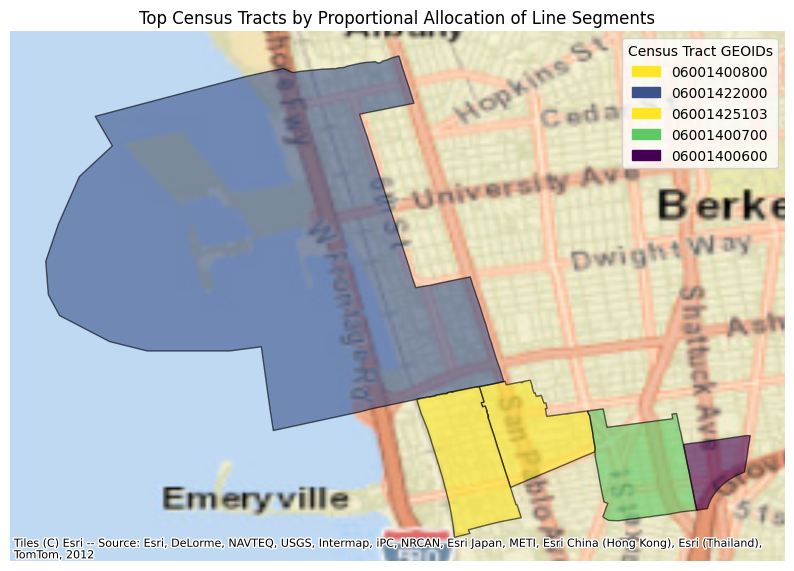

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Merge the proportion data back into the census tracts GeoDataFrame with suffixes to avoid duplication
merged_data = census_tracts.merge(grouped, on='GEOID', how='inner', suffixes=('', '_grouped'))

# Filter to include only the top entries (you could adjust the number as needed)
top_tracts = merged_data.nlargest(5, 'proportion_grouped')  # Adjust number for more tracts

# Assuming 'top_tracts' is already filtered and ready for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Create a colormap with a distinct color for each tract
num_tracts = len(top_tracts)
cmap = plt.cm.get_cmap('viridis', num_tracts)

# Plot each tract individually to assign unique colors and create legend handles
legend_handles = []
for i, row in top_tracts.iterrows():
    color = cmap(i / num_tracts)
    top_tracts[top_tracts['GEOID'] == row['GEOID']].plot(ax=ax, color=color, alpha=0.6, linewidth=1, edgecolor='black')
    legend_handles.append(mpatches.Patch(color=color, label=row['GEOID']))

# Add the legend to the plot
ax.legend(handles=legend_handles, title="Census Tract GEOIDs", loc='upper right')

# Add a basemap for geographic context
ctx.add_basemap(ax, crs=top_tracts.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, zoom=12)

# Setting plot parameters
ax.set_title('Top Census Tracts by Proportional Allocation of Line Segments')
ax.set_axis_off()  # Turns off the axis

plt.show()


0       1251
1       4027
2       7843
3        381
4       1265
        ... 
9124    5055
9125    5056
9126    5057
9127     566
9128     567
Name: color, Length: 9129, dtype: int16


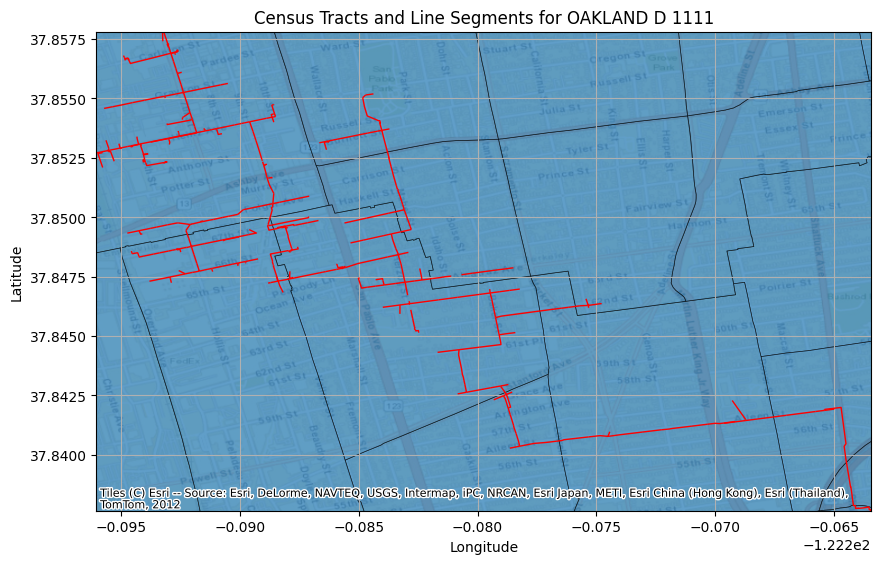

In [ ]:
import matplotlib.patches as mpatches

# Step 3: Filter Line Data for a Specific Feeder
feeder_name = 'OAKLAND D 1111'
filtered_lines = line[line['FeederName'] == feeder_name]

# Step 4: Ensure CRS Matches
filtered_lines = filtered_lines.to_crs(census_tracts.crs)

# Step 5: Get the bounding box of the filtered lines
bounding_box = filtered_lines.total_bounds

# Step 6: Plot the Map with Overlaid Census Tracts and Line Segments
fig, ax = plt.subplots(figsize=(10, 10))

# Assign a unique color to each census tract using a colormap
census_tracts['color'] = pd.Categorical(census_tracts['GEOID']).codes

print(census_tracts['color'])
# Assign a unique color to each census tract using a colormap
census_tracts.plot(column='color', ax=ax, cmap='tab20', edgecolor='black', linewidth=0.5, alpha=0.7)

# Plot the filtered line segments
filtered_lines.plot(ax=ax, color='red', linewidth=1)

# Set the extent to the bounding box of the filtered lines
ax.set_xlim([bounding_box[0], bounding_box[2]])
ax.set_ylim([bounding_box[1], bounding_box[3]])

# Add basemap for geographic context
ctx.add_basemap(ax, crs=census_tracts.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, alpha=0.8)

# Create legend handles
unique_colors = census_tracts['color'].unique()
patches = [mpatches.Patch(color=plt.cm.tab20(color), label=tract) for color, tract in zip(unique_colors, census_tracts['GEOID'].unique())]

# Add the legend
# ax.legend(handles=patches, title="Census Tracts", loc='upper right', bbox_to_anchor=(1.35, 1))

# Set plot titles and labels
ax.set_title(f"Census Tracts and Line Segments for {feeder_name}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the map
plt.grid(True)
plt.show()

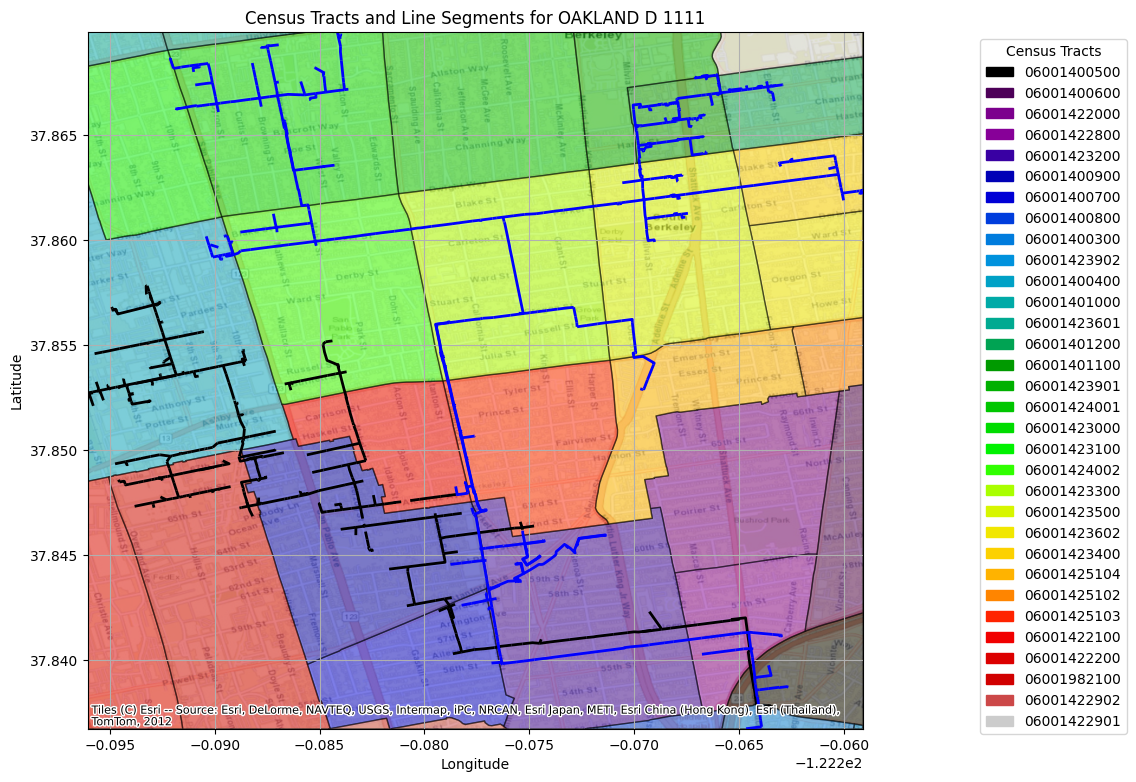

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.patches as mpatches
from shapely.geometry import box
from matplotlib.colors import ListedColormap

# Filter Line Data for Specific Feeders
feeder_names = ['OAKLAND D 1111', 'OAKLAND D 1105']
filtered_lines = line[line['FeederName'].isin(feeder_names)]

# Ensure CRS Matches
filtered_lines = filtered_lines.to_crs(census_tracts.crs)

# Get the bounding box of the filtered lines and create a bounding box geometry
bbox = box(*filtered_lines.total_bounds)
bounding_box = gpd.GeoDataFrame({'geometry': [bbox]}, crs=filtered_lines.crs)

# Filter census tracts to those that intersect with the bounding box
census_tracts_filtered = gpd.overlay(census_tracts, bounding_box, how='intersection')

# Plot the Map with Overlaid Census Tracts and Line Segments
fig, ax = plt.subplots(figsize=(10, 10))

# Create a ListedColormap with as many colors as there are filtered tracts
num_tracts = len(census_tracts_filtered['GEOID'].unique())
cmap = plt.get_cmap('nipy_spectral', num_tracts)  # More colors

# Assign a unique color to each census tract using the new colormap
census_tracts_filtered['color'] = pd.Categorical(census_tracts_filtered['GEOID']).codes
census_tracts_filtered.plot(column='color', ax=ax, cmap=cmap, edgecolor='black', linewidth=1, alpha=0.5)

# Plot the filtered line segments
colors = ['black', 'blue']  # Different color for each feeder line
for (name, color) in zip(feeder_names, colors):
    lines_subset = filtered_lines[filtered_lines['FeederName'] == name]
    lines_subset.plot(ax=ax, color=color, linewidth=2, label=name)

# Set the extent to the bounding box of the filtered lines
ax.set_xlim([bbox.bounds[0], bbox.bounds[2]])
ax.set_ylim([bbox.bounds[1], bbox.bounds[3]])

# Add basemap for geographic context
ctx.add_basemap(ax, crs=census_tracts_filtered.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, alpha=0.8)

# Create legend handles (update this part as per your number of tracts and colors)
patches = [mpatches.Patch(color=cmap(i/num_tracts), label=str(tract)) for i, tract in enumerate(census_tracts_filtered['GEOID'].unique())]

# Optionally add the legend
ax.legend(handles=patches, title="Census Tracts", loc='upper right', bbox_to_anchor=(1.35, 1))

# Set plot titles and labels
ax.set_title(f"Census Tracts and Line Segments for {feeder_name}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Display the map
plt.grid(True)
plt.show()